<a href="https://colab.research.google.com/github/ldaniel/Advanced-Predictive-Analytics/blob/master/Autoencoder_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape

%matplotlib inline

In [0]:
#@title
def plot_random_batch(batch, y_true, y_pred=None, batch_size=30, n_cols=10, figsize=(20, 10)):
    plt.figure(figsize=figsize)

    random_idx = np.random.choice(batch.shape[0], size=batch_size)
    x_batch = batch[random_idx].squeeze()
    y_batch = y_true[random_idx]
    
    y_pred = y_batch if y_pred is None else y_pred[random_idx]
    n_rows = x_batch.shape[0] // n_cols + 1
    is_gray = (batch.shape[-1] == 1) or (len(batch.shape) == 3)
    for img, true, pred, sub in zip(x_batch, y_batch, y_pred, range(1, len(batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8), cmap='gray' if is_gray else None)
        
        plt.title("T:{} P:{}".format(true, pred), color = 'green' if true == pred else 'red')
        plt.axis('off')
    plt.tight_layout()

def plot_history(history, figsize=(12, 4), loss_train_key='loss', loss_val_key='val_loss', metric_train_key='accuracy', metric_val_key='val_accuracy'):
    loss_train = history.get(loss_train_key, [])
    loss_valid = history.get(loss_val_key, [])
    metric_train = history.get(metric_train_key, [])
    metric_valid = history.get(metric_val_key, [])

    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='train')
    plt.plot(loss_valid, label='val')
    plt.ylim(0)
    plt.legend()

    if len(metric_train) > 0 or len(metric_valid) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(metric_train, label='train')
        plt.plot(metric_valid, label='val')
        plt.ylim(top=1)
        plt.legend()

# Data Loading

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, x_train.dtype)
print(x_test.shape, x_test.dtype)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) uint8
(10000, 28, 28) uint8


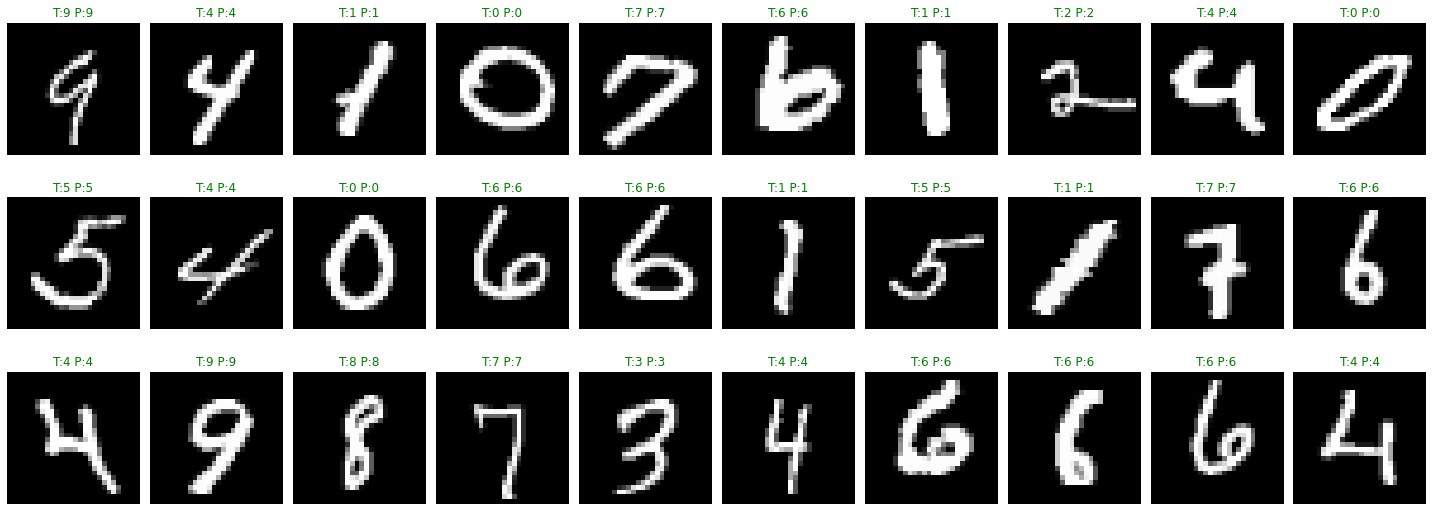

In [0]:
plot_random_batch(x_train, y_train)

# Autoencoder

In [0]:
x_train = x_train.reshape(-1, 28*28) / 255
x_test = x_test.reshape(-1, 28*28) / 255

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
encoded (Dense)              (None, 2)                 258       
_________________________________________________________________
dec_1 (Dense)                (None, 128)               384       
_________________________________________________________________
dec_2 (Dense)                (None, 512)               66048     
_________________________________________________________________
decoded (Dense)              (None, 784)               402192    
Total params: 936,466
Trainable params: 936,466
Non-trainable params: 0
__________________________________________________

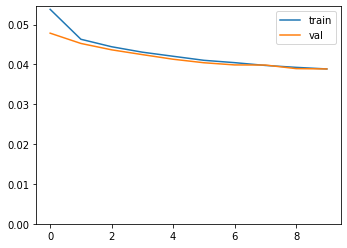

In [0]:
model = Sequential([
    # encoder
    Dense(units=512, activation='relu', input_dim=28*28), 
    Dense(units=128, activation='relu'), 
    Dense(units=2, activation='linear', name='encoded'), 

    # decoder
    Dense(units=128, activation='relu', name='dec_1'), 
    Dense(units=512, activation='relu', name='dec_2'), 
    Dense(units=28*28, activation='linear', name='decoded')
])
model.summary()

# mse pra tentar predizer o valor do pixel
model.compile(optimizer='adam', loss='mse')

hist = model.fit(x_train, x_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

plot_history(hist.history)

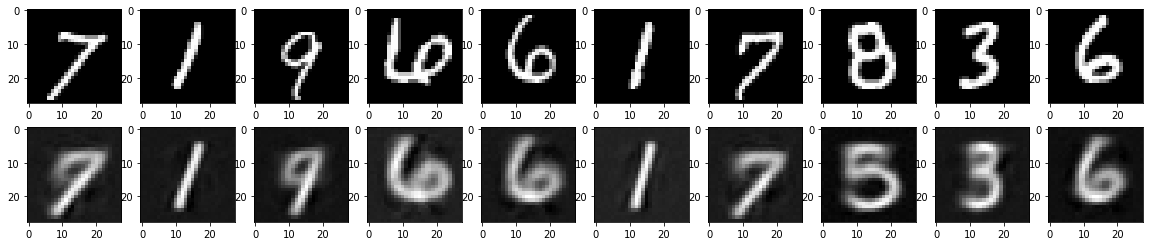

In [0]:
n_imgs = 10

random_idxs = np.random.choice(range(x_test.shape[0]), size=n_imgs)
im_ori = x_test[random_idxs]
im_dec = model.predict(im_ori)

plt.figure(figsize=(20, 4))
for i in range(n_imgs):
    plt.subplot(2, n_imgs, i + 1)
    plt.imshow(im_ori[i].reshape(28, 28), cmap='gray')
    
    plt.subplot(2, n_imgs, i + 1 + n_imgs)
    plt.imshow(im_dec[i].reshape(28, 28), cmap='gray')

# Visualizando os embeddings

In [0]:
encoder = Model(inputs=model.input, outputs=model.get_layer(name='encoded').output)
x_test_enc = encoder.predict(x_test)
x_test_enc.shape

(10000, 2)

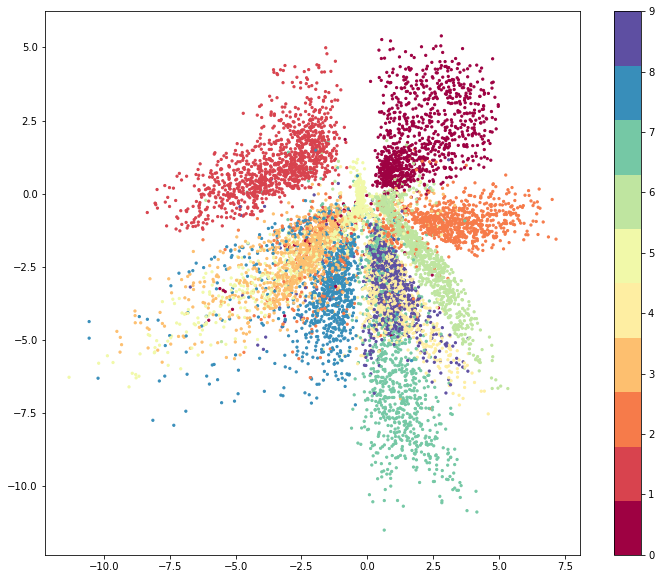

In [0]:
plt.figure(figsize=(12, 10))
plt.scatter(x_test_enc[:, 0], x_test_enc[:, 1], c=y_test, cmap=plt.cm.get_cmap('Spectral', 10), s=5)
plt.colorbar()

# Reconstruindo uma imagem

In [0]:
decoder = Sequential()
decoder.add(Dense(units=128, activation='relu', input_dim=2))
decoder.add(Dense(units=512, activation='relu'))
decoder.add(Dense(units=784, activation='linear'))
decoder.summary()

weights = []
for layer in ['dec_1', 'dec_2', 'decoded']:
    w = model.get_layer(layer).get_weights()
    weights.append(w[0])
    weights.append(w[1])

decoder.set_weights(weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
Total params: 468,624
Trainable params: 468,624
Non-trainable params: 0
_________________________________________________________________


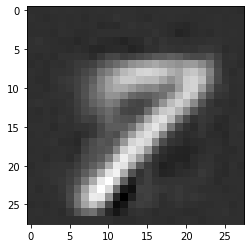

In [0]:
im_pred = decoder.predict(np.array([[0, -7.5]])).reshape((28, 28))
plt.imshow(im_pred, cmap='gray')